In [1014]:
import random
import numpy as np
import matplotlib.pyplot as plt
import forward_backward as fb
np.random.seed(12345)

In [1460]:
def generating_states(pi,A,Ntimes):
    
    Q = np.empty(Ntimes).astype('int')

    Nstates=np.shape(A)[0]
    
    states = np.zeros((Nstates, Ntimes))
    
    Q[0]=np.random.choice(Nstates,1,p=pi)[0]
    
    states[int(Q[0]),0]=1
    
    for t in range(1, Ntimes):
        
        Q[t]=np.random.choice(Nstates,1,p=A[Q[t-1]])[0]
        
        states[Q[t],t]=1
        
    return Q, states

In [1461]:
pi=np.array([.8,.2])
A = np.array([[.9, .1, ], [.2, .8]])
B = np.array([[.9, .05, .05], [.1, .2, .7]])
Ntimes=20000
Nstates=2

In [1462]:
Q, states=generating_states(pi,A,Ntimes)

#np.savetxt

In [1463]:
def generating_observations(Q,B):

    Ntimes=np.size(Q)
    
    O = np.empty(Ntimes).astype('int')
    
    Nstates=np.size(B[:,0])
    
    Nobservations= np.size(B[0,:])
    
    O_mat=np.zeros((Nobservations,Ntimes))
    
    for t in range(Ntimes):
        
        O[t]=np.random.choice(Nobservations,1,p=B[Q[t]])[0]
        
        O_mat[O[t],t]=1
        
    return O, O_mat

In [1464]:

O, O_mat = generating_observations(Q,B)    

#Generate observations from the state
#do forward to due to the probabliities

In [1465]:
def forward_online(O, A_guess, B_guess, pi):
    
    T = O.shape[0]
    
    N = A_guess.shape[0]
    
    alpha = np.zeros((N, T-1))# p(z_t|y_{1:T})
    gamma = np.zeros((N, T-1))# p(z_t|y_{1:T})
    delta = np.empty((N,N,T-1))
    xi=np.empty((N,N))
    test=np.empty((N,N))
    
    err=np.zeros(T)
    err2=np.zeros(T)
    S=np.zeros(T)
    store=np.zeros(T)
    a=np.zeros(N)
    count=np.zeros(N)
    theta=10**-3
    Xi=np.zeros((N,N))
    alpha[:,0]=pi*B_guess[:,int(O[0])]
        
    alpha[:,0]=alpha[:,0]/sum(alpha[s,0] for s in range(N))
    
    N, Nobservations = B_guess.shape
    
    b=np.zeros((N,Nobservations))
    
    A_true = np.array([[.9, .1, ], [.2, .8]])
#     A_guess = np.array([[.9, .1, ], [.2, .8]])
    B_true = np.array([[.9, .05, .05], [.1, .2, .7]])
    
   
    #T=19
    
    for t in range(1,T-1):    
        asum = 0.0    
        xisum= 0.0

        #Forward Step
        for s in range(N):

            alpha[s,t]=sum([alpha[j,t-1]*A_guess[j,s]*B_guess[s,int(O[t])] for j in range(N)])

            asum += alpha[s,t] 

        for s in range(N):       

            alpha[s,t] =alpha[s,t]/asum

        a = theta*alpha[:,t]+(1-theta)*a

        #E-step

        for s in range(N):

            for j in range(N):

                xi[s,j]=B_guess[j,int(O[t])]*A_guess[s,j]*alpha[s,t-1]

                xisum += xi[s,j]

        xi=xi/xisum

        Xi = theta*xi+(1-theta)*Xi

        for v in range(Nobservations):

            for j in range(N):

                if v==O[t]:

                    b[j,v] = theta*alpha[j,t]+(1-theta)*(b[j,v])         

                    B_guess[j,v]=b[j,v]/a[j]
                    
                else:
                    
                    b[j,v]=(1-theta)*(b[j,v])
                    
                    
#         for v in range(Nobservations):

#             if v==O[t]:

#                 jj= np.argmax(alpha[:,t])   
                    
#                 b[jj,v] += 1
                
#                 count[jj] += 1
                
#                 B_guess[jj,v]=b[jj,v]/count[jj]
            
        S[t]=np.linalg.norm(A_guess-Xi/a)
        store[t]=S[t]-S[t-1]
        if abs(store[t])<.0008 :
            S[t]=S[t]
        else:
            for s in range(N):
                A_guess[:,s]= Xi[s,:]/a

        err[t]=np.linalg.norm(A_true-A_guess)
        err2[t]=np.linalg.norm(B_true-B_guess)

    A= A_guess
    B= B_guess
    
    return A, B, xi, alpha, b, a, err, err2, S, store, 

[[0.88926581 0.11073419]
 [0.20831247 0.79168753]]
[[0.90060034 0.05134235 0.04874654]
 [0.11988144 0.19471613 0.68747781]]


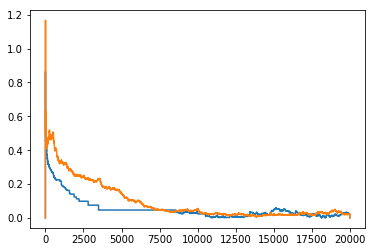

In [1466]:
A = np.array([[.65, .35 ], [.1, .9]])  #incorrect guesses
B = np.array([[.7, .2, .1], [.1, .3, .6]]) #incorrect guesses
#A = np.array([[.9, .1, ], [.2, .8]]) #correct A
#B = np.array([[.9, .05, .05], [.1, .2, .7]]) #correct B guess
A_guess, B_guess, xi, alpha, b, a, err, err2,dif,dif2 =forward_online(O, A, B, pi)

print(A_guess)
print(B_guess)
plt.plot(err)
plt.plot(err2)

In [1428]:
true_count=np.zeros((2,3))
for s in range(2):
    for v in range(3):
        true_count[s,v]=sum(O[Q==s]==v)
print(true_count) # number of times an observation was correctly observed at a given state

print(((true_count).T/np.sum(true_count,1)).T) #nuumber of times an o

[[11983.   704.   695.]
 [  675.  1324.  4619.]]
[[0.89545658 0.05260798 0.05193544]
 [0.10199456 0.20006044 0.697945  ]]


In [1467]:
err2[9998]

0.05418241064981846

In [1468]:
err[9998]

0.03402030181388804

In [1239]:
dif2[abs(dif2)<.000002]

array([ 0.00000000e+00,  5.33666037e-07, -1.44182332e-06,  9.43333416e-07,
        1.31952145e-07,  1.12917968e-06, -1.29164788e-06, -1.96661407e-06,
       -1.92396947e-06, -1.07921777e-06,  9.43836151e-07, -9.43868470e-07,
       -1.29200594e-06,  6.87262862e-07,  1.91296239e-06,  7.87903734e-07,
       -4.47112314e-08,  1.12537620e-06,  1.47605141e-06,  0.00000000e+00])

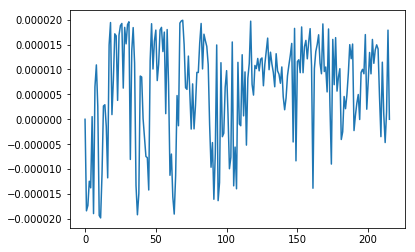

In [1233]:
plt.plot(dif2[abs(dif2)<.00002])

In [918]:
b

array([[213.22390574,  11.16416851,  19.75915879],
       [ 45.12496379,  10.63464544,  42.44732672]])

In [1158]:
np.savetxt('Q',Q)
np.savetxt('O',O)

In [1161]:
O=np.loadtxt('O')
Q=np.loadtxt('Q')

In [1160]:
O

array([1., 2., 1., ..., 1., 2., 0.])

In [1192]:
dif?

Object `dif` not found.


In [1193]:
np.dif

AttributeError: module 'numpy' has no attribute 'dif'